In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE

In [2]:
data = pandas.read_csv('./2021train.csv', low_memory=False)
test_data = pandas.read_csv('./2021test.csv', low_memory=False)

In [3]:
def strip_and_prepare_data(raw_data):
    data_copy = raw_data.copy(deep=True)
    mean_age = data_copy['Age'].mean()

    data_copy.loc[(data_copy.Age.isna()), 'Age']= mean_age
    data_copy.loc[data_copy.Embarked.isna(), 'Embarked'] = 1
    data_copy.loc[(data_copy.Embarked == 'C'), 'Embarked'] = 1
    data_copy.loc[(data_copy.Embarked == 'S'), 'Embarked'] = 2
    data_copy.loc[(data_copy.Embarked == 'Q'), 'Embarked'] = 3
    data_copy.loc[(data_copy.Sex == 'female'), 'Sex'] = 0
    data_copy.loc[(data_copy.Sex == 'male'), 'Sex'] = 1
    data_copy['Is_child'] = data_copy['Age'].apply(lambda age: 1 if age < 18 else 0)


    def assign_title(name):
        titles = {
            'Mrs': 1,
            'Mr': 2,
            'Miss': 3,
            'Master': 4,
            'Other': 5
        }
        for title in titles.keys():
            if title in name:
                return titles[title]
        return titles['Other']

    data_copy['Has_Cabin'] = data_copy["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    data_copy['Title'] = data_copy['Name'].apply(assign_title)
    data_copy.loc[data_copy['Fare'].isna(), 'Fare'] = 0
    data_copy.loc[data_copy['Fare'] <= 7.91, 'Fare'] = 0
    data_copy.loc[(data_copy['Fare'] > 7.91) & (data_copy['Fare'] <= 14.454), 'Fare'] = 1
    data_copy.loc[(data_copy['Fare'] > 14.454) & (data_copy['Fare'] <= 31), 'Fare'] = 2
    data_copy.loc[data_copy['Fare'] > 31, 'Fare'] = 3

    data_copy.loc[data_copy['Age'] <= 16, 'Age'] = 0
    data_copy.loc[(data_copy['Age'] > 16) & (data_copy['Age'] <= 32), 'Age'] = 1
    data_copy.loc[(data_copy['Age'] > 32) & (data_copy['Age'] <= 48), 'Age'] = 2
    data_copy.loc[(data_copy['Age'] > 48) & (data_copy['Age'] <= 64), 'Age'] = 3
    data_copy.loc[data_copy['Age'] > 64, 'Age'] = 4
    return data_copy

In [4]:
stripped_data = strip_and_prepare_data(data)

In [5]:
stripped_data

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_child,Has_Cabin,Title
0,1,1,0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,A/5 21171,0.0,NaN,2,0,0,2
1,2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,PC 17599,3.0,C85,1,0,1,1
2,3,3,1,3,"Heikkinen, Miss. Laina",0,1.0,0,0,STON/O2. 3101282,1.0,NaN,2,0,0,3
3,4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,113803,3.0,C123,2,0,1,1
4,5,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,373450,1.0,NaN,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,885,885,0,3,"Sutehall, Mr. Henry Jr",1,1.0,0,0,SOTON/OQ 392076,0.0,NaN,2,0,0,2
664,886,886,0,3,"Rice, Mrs. William (Margaret Norton)",0,2.0,0,5,382652,2.0,NaN,3,0,0,1
665,887,887,0,2,"Montvila, Rev. Juozas",1,1.0,0,0,211536,1.0,NaN,2,0,0,5
666,888,888,1,1,"Graham, Miss. Margaret Edith",0,1.0,0,0,112053,2.0,B42,2,0,1,3


In [8]:
def prepare_x(stripped_data, columns):
    prepared_data_x = stripped_data[columns].to_numpy(dtype='float64', copy=True)
    return prepared_data_x

def count_unique(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

In [9]:
#prepared_data_x = stripped_data[['Pclass', 'Title', 'Sex', 'Age', 'Is_child', 'SibSp', 'Parch', 'Fare', 'Embarked']].to_numpy(dtype='float64', copy=True)
#prepared_data_x = prepare_x(stripped_data, ['Pclass', 'Sex',  'Age','Title','Is_child','Fare', 'Has_Cabin'])
#prepared_data_x = prepare_x(stripped_data, ['Pclass', 'Sex', 'Has_Cabin', 'Parch', 'Embarked'])
#prepared_data_x = prepare_x(stripped_data, ['Pclass', 'Sex', 'Title', 'Is_child', 'Has_Cabin', 'Parch', 'Embarked'])
#selected_columns = ['Sex', 'Age', 'SibSp', 'Title', 'Is_child', 'Has_Cabin']
#selected_columns = ['Pclass', 'Sex',  'Age', 'SibSp', 'Title','Is_child','Fare', 'Has_Cabin', 'Parch', 'Embarked',]
selected_columns = ['Sex', 'Age', 'SibSp', 'Title', 'Is_child', 'Pclass']

prepared_data_x = prepare_x(stripped_data, selected_columns)
prepared_data_y =  stripped_data[['Survived']].to_numpy(dtype='float64', copy=True)

print(prepared_data_x.shape)
print(prepared_data_y.shape)

(668, 6)
(668, 1)


In [10]:
def remove_outliers(x, y):
    isf = IsolationForest(n_jobs=-1, random_state=1)
    isf.fit(x, y)
    outliers_mask = isf.predict(x) == 1
    return x[outliers_mask, :], y[outliers_mask, :]

In [11]:
prepared_data_x2, prepared_data_y2 = remove_outliers(prepared_data_x, prepared_data_y)
print(prepared_data_x2.shape)
print(prepared_data_y2.shape)

(364, 6)
(364, 1)


In [163]:
def print_most_important_labels():
    TOP_FEATURES = len(selected_columns)

    forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
    forest.fit(prepared_data_x, prepared_data_y)

    importances = forest.feature_importances_
    std = np.std(
        [tree.feature_importances_ for tree in forest.estimators_],
        axis=0
    )
    indices = np.argsort(importances)[::-1]
    indices = indices[:TOP_FEATURES]

    print('Top features:')
    for i in range(TOP_FEATURES):
        print(f'{i}. feature {indices[i]} name {selected_columns[i]} value {importances[indices[i]]}')
print_most_important_labels()

Top features:
0. feature 1 name Pclass value 0.4855467947726432
1. feature 0 name Sex value 0.151148889612253
2. feature 7 name Age value 0.10635261462583437
3. feature 4 name SibSp value 0.10564509064342031
4. feature 6 name Title value 0.04499282880009326
5. feature 3 name Is_child value 0.028483462763037606
6. feature 9 name Fare value 0.022459183796257557
7. feature 5 name Has_Cabin value 0.020674147687881728
8. feature 8 name Parch value 0.020420739908508692
9. feature 2 name Embarked value 0.014276247390070277


C:\Users\Olexandr\AppData\Local\Temp/ipykernel_976/3886769042.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(prepared_data_x, prepared_data_y)


In [56]:
count_unique(prepared_data_y)

{0.0: 415, 1.0: 253}

In [10]:
def add_synthetic_data(x,y):
    smote = SMOTE(sampling_strategy='minority', random_state=9, n_jobs=-1)
    x_sm, y_sm = smote.fit_resample(x, y)
    print(count_unique(y_sm))
    return x_sm, y_sm

In [67]:
x_sm, y_sm = add_synthetic_data(prepared_data_x2, prepared_data_y2)

{0.0: 270, 1.0: 270}


In [93]:
x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size = 0.1, random_state = 3, stratify=y_sm)
#x_train, x_test, y_train, y_test = train_test_split(prepared_data_x2, prepared_data_y2, test_size = 0.1, random_state = 9, stratify=prepared_data_y2)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(count_unique(y_train))
print(count_unique(y_test))

#, stratify=prepared_data_y

(486, 6)
(486,)
(54, 6)
(54,)
{0.0: 243, 1.0: 243}
{0.0: 27, 1.0: 27}


In [14]:
def assess_prediction(predicted, actual):
    predicted =  np.abs(np.rint(predicted))
    percents =  metrics.accuracy_score(y_true=actual, y_pred=predicted)
    print('percent score: ', percents)
    print('mean_squared score: ', metrics.mean_squared_error(y_true=actual, y_pred=predicted))
    print('median_absolute score: ', metrics.median_absolute_error(y_true=actual, y_pred=predicted))
    return percents

In [94]:
reg = LinearRegression().fit(x_train, y_train)
predicted = reg.predict(x_test)
assess_prediction(predicted, y_test)

percent score:  0.7962962962962963
mean_squared score:  0.2037037037037037
median_absolute score:  0.0


0.7962962962962963

In [70]:
log = LogisticRegression(max_iter=1000).fit(x_train, y_train)
predicted = log.predict(x_test)
assess_prediction(predicted, y_test)

percent score:  0.7962962962962963
mean_squared score:  0.2037037037037037
median_absolute score:  0.0


0.7962962962962963

In [72]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=0.0001)
svm.fit(x_train, y_train)
predicted = svm.predict(x_test)
assess_prediction(predicted, y_test)

percent score:  0.6111111111111112
mean_squared score:  0.3888888888888889
median_absolute score:  0.0


0.6111111111111112

In [83]:
clf = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
predicted = clf.predict(x_test)
assess_prediction(predicted, y_test)

percent score:  0.8148148148148148
mean_squared score:  0.18518518518518517
median_absolute score:  0.0


0.8148148148148148

In [38]:
stripped_data.columns

Index(['Unnamed: 0', 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Is_child',
       'Has_Cabin', 'Title'],
      dtype='object')

In [93]:
kek = []
from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

len(list(powerset(['Pclass', 'Sex',  'Age', 'SibSp', 'Title','Is_child','Fare', 'Has_Cabin', 'Parch', 'Embarked', ])))

def find_best_params():
    res = []
    for columns in list(powerset(['Pclass', 'Sex',  'Age', 'SibSp', 'Title','Is_child','Fare', 'Has_Cabin', 'Parch', 'Embarked', ])):
        if not columns:
            continue
        for random_state in range(1, 10):
            pdx = prepare_x(stripped_data, list(columns))
            pdy =  stripped_data[['Survived']].to_numpy(dtype='float64', copy=True)
            x_train1, x_test1, y_train1, y_test1 = train_test_split(pdx, pdy, test_size = 0.2, random_state = random_state, stratify=pdy)
            reg1 = LinearRegression().fit(x_train1, y_train1)
            predicted1 = reg1.predict(x_test1)
            perc = assess_prediction(predicted1, y_test1)
            res.append((perc, random_state, columns))
    return res
wtf = find_best_params()


percent score:  0.6865671641791045
mean_squared score:  0.31343283582089554
median_absolute score:  0.0
percent score:  0.7089552238805971
mean_squared score:  0.291044776119403
median_absolute score:  0.0
percent score:  0.6268656716417911
mean_squared score:  0.373134328358209
median_absolute score:  0.0
percent score:  0.6940298507462687
mean_squared score:  0.30597014925373134
median_absolute score:  0.0
percent score:  0.6716417910447762
mean_squared score:  0.3283582089552239
median_absolute score:  0.0
percent score:  0.7089552238805971
mean_squared score:  0.291044776119403
median_absolute score:  0.0
percent score:  0.6791044776119403
mean_squared score:  0.3208955223880597
median_absolute score:  0.0
percent score:  0.6716417910447762
mean_squared score:  0.3283582089552239
median_absolute score:  0.0
percent score:  0.6492537313432836
mean_squared score:  0.35074626865671643
median_absolute score:  0.0
percent score:  0.753731343283582
mean_squared score:  0.2462686567164179

In [94]:
wtf.sort(key=lambda y: y[0])
wtf[-10:]

[(0.8731343283582089,
  9,
  ('Sex', 'SibSp', 'Title', 'Is_child', 'Fare', 'Embarked')),
 (0.8731343283582089,
  9,
  ('Pclass', 'Sex', 'SibSp', 'Title', 'Is_child', 'Fare', 'Parch')),
 (0.8731343283582089,
  9,
  ('Sex', 'Age', 'SibSp', 'Title', 'Is_child', 'Fare', 'Embarked')),
 (0.8805970149253731, 9, ('Pclass', 'Sex', 'SibSp', 'Is_child')),
 (0.8805970149253731, 9, ('Pclass', 'Sex', 'SibSp', 'Parch')),
 (0.8805970149253731, 9, ('Sex', 'SibSp', 'Is_child', 'Has_Cabin')),
 (0.8805970149253731, 9, ('Pclass', 'Sex', 'SibSp', 'Fare', 'Parch')),
 (0.8805970149253731, 9, ('Sex', 'Age', 'SibSp', 'Is_child', 'Has_Cabin')),
 (0.8805970149253731, 9, ('Sex', 'SibSp', 'Title', 'Is_child', 'Has_Cabin')),
 (0.8805970149253731,
  9,
  ('Sex', 'Age', 'SibSp', 'Title', 'Is_child', 'Has_Cabin'))]

In [48]:
list(powerset(['Pclass', 'Sex',  'Age', 'SibSp', 'Title','Is_child','Fare', 'Has_Cabin', 'Parch', 'Embarked', ]))

[(),
 ('Pclass',),
 ('Sex',),
 ('Age',),
 ('SibSp',),
 ('Title',),
 ('Is_child',),
 ('Fare',),
 ('Has_Cabin',),
 ('Parch',),
 ('Embarked',),
 ('Pclass', 'Sex'),
 ('Pclass', 'Age'),
 ('Pclass', 'SibSp'),
 ('Pclass', 'Title'),
 ('Pclass', 'Is_child'),
 ('Pclass', 'Fare'),
 ('Pclass', 'Has_Cabin'),
 ('Pclass', 'Parch'),
 ('Pclass', 'Embarked'),
 ('Sex', 'Age'),
 ('Sex', 'SibSp'),
 ('Sex', 'Title'),
 ('Sex', 'Is_child'),
 ('Sex', 'Fare'),
 ('Sex', 'Has_Cabin'),
 ('Sex', 'Parch'),
 ('Sex', 'Embarked'),
 ('Age', 'SibSp'),
 ('Age', 'Title'),
 ('Age', 'Is_child'),
 ('Age', 'Fare'),
 ('Age', 'Has_Cabin'),
 ('Age', 'Parch'),
 ('Age', 'Embarked'),
 ('SibSp', 'Title'),
 ('SibSp', 'Is_child'),
 ('SibSp', 'Fare'),
 ('SibSp', 'Has_Cabin'),
 ('SibSp', 'Parch'),
 ('SibSp', 'Embarked'),
 ('Title', 'Is_child'),
 ('Title', 'Fare'),
 ('Title', 'Has_Cabin'),
 ('Title', 'Parch'),
 ('Title', 'Embarked'),
 ('Is_child', 'Fare'),
 ('Is_child', 'Has_Cabin'),
 ('Is_child', 'Parch'),
 ('Is_child', 'Embarked'),
 ('F

In [63]:
wtf = find_best_params()

In [52]:
wtf

[(0.8208955223880597, ())]

In [19]:
y_train = np.reshape(y_train, newshape=(y_train.shape[0]))
y_test = np.reshape(y_test, newshape=(y_test.shape[0]))
y_train.shape

(559,)

In [20]:
forest = RandomForestClassifier(n_estimators=50, max_depth=6, random_state=6)
forest.fit(x_train, y_train)
predicted = forest.predict(x_test)
assess_prediction(predicted, y_test)

percent score:  0.8412698412698413
mean_squared score:  0.15873015873015872
median_absolute score:  0.0


0.8412698412698413

In [72]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'n_estimators': list(range(50,200)),
    'max_depth': list(range(2,8)),
    'random_state': list(range(1,10))
}
clf = GridSearchCV(
    RandomForestClassifier(), parameters, scoring='accuracy', n_jobs=12
)
clf.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=12,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [50, 51, 52, 53, 54, 55, 56, 57, 58,
                                          59, 60, 61, 62, 63, 64, 65, 66, 67,
                                          68, 69, 70, 71, 72, 73, 74, 75, 76,
                                          77, 78, 79, ...],
                         'random_state': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='accuracy')

In [73]:
#{'max_depth': 5, 'n_estimators': 75, 'random_state': 1}
#{'max_depth': 4, 'n_estimators': 65, 'random_state': 1}
#{'max_depth': 6, 'n_estimators': 50, 'random_state': 6}
clf.best_params_

{'max_depth': 6, 'n_estimators': 50, 'random_state': 6}

In [79]:
titanic_model = Sequential()
titanic_model.add(Dense(10,kernel_initializer='uniform',  input_shape=(6,), activation='relu'))
titanic_model.add(Dense(10,kernel_initializer='uniform', activation='relu'))
titanic_model.add(Dense(5,kernel_initializer='uniform', activation='relu'))
titanic_model.add(Dense(1,kernel_initializer='uniform',  activation='sigmoid'))

titanic_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
titanic_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 10)                70        
                                                                 
 dense_20 (Dense)            (None, 10)                110       
                                                                 
 dense_21 (Dense)            (None, 5)                 55        
                                                                 
 dense_22 (Dense)            (None, 1)                 6         
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [195]:
#sgd = SGD(learning_rate=0.01, momentum=0.8, nesterov=True)
#titanic_model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
#titanic_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
history = titanic_model.fit(x_train, y_train, epochs=25, batch_size=16)

Epoch 1/25
31/31 [==============================] - 0s 700us/step - loss: 0.6932 - accuracy: 0.5021
Epoch 2/25
31/31 [==============================] - 0s 700us/step - loss: 0.6931 - accuracy: 0.5000
Epoch 3/25
31/31 [==============================] - 0s 700us/step - loss: 0.6927 - accuracy: 0.5000
Epoch 4/25
31/31 [==============================] - 0s 700us/step - loss: 0.6912 - accuracy: 0.5000
Epoch 5/25
31/31 [==============================] - 0s 667us/step - loss: 0.6867 - accuracy: 0.5123
Epoch 6/25
31/31 [==============================] - 0s 700us/step - loss: 0.6784 - accuracy: 0.6029
Epoch 7/25
31/31 [==============================] - 0s 867us/step - loss: 0.6669 - accuracy: 0.6276
Epoch 8/25
31/31 [==============================] - 0s 700us/step - loss: 0.6527 - accuracy: 0.7037
Epoch 9/25
31/31 [==============================] - 0s 700us/step - loss: 0.6393 - accuracy: 0.7037
Epoch 10/25
31/31 [==============================] - 0s 667us/step - loss: 0.6252 - accuracy: 0.7037

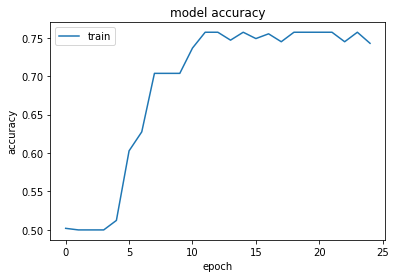

In [81]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [82]:
kek = titanic_model.predict(x_test)
assess_prediction(kek, y_test)

percent score:  0.7962962962962963
mean_squared score:  0.2037037037037037
median_absolute score:  0.0


0.7962962962962963

In [401]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(x_train, y_train)
Y_pred = classifier.predict(x_test)
assess_prediction(Y_pred)

percent score:  0.7014925373134329
mean_squared score:  0.29850746268656714
median_absolute score:  0.0


In [21]:
def load_result(csv_name, model):
    stripped_test_data = strip_and_prepare_data(test_data)
    x_test2 = prepare_x(stripped_test_data, selected_columns)
    kek2 = model.predict(x_test2)
    predicted2 =  np.abs(np.rint(kek2)).astype('int')
    stripped_test_data['Survived'] = predicted2
    res1 = stripped_test_data[['PassengerId', 'Survived']]
    res1.to_csv(csv_name, index=False)

In [84]:
load_result('.\\decision1.csv', clf)